In [1]:
import os
import sys
import cv2
import torch
import random
import numpy as np

sys.path.append("../")


/Users/riccardomusmeci/progetti/github/smart-arrotino/venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from src.io.config import load_yml
from src.utils.utils import visualize
from src.transform.transform import transform
from src.model.utils import segmentation_model
from src.dataset.road_dataset import RoadDataset
from src.io.io import load_state_dict_from_ckpt, read_rgb
from src.model.segmentation_module import RoadSegmentationModule

/Users/riccardomusmeci/progetti/github/smart-arrotino/venv/lib/python3.9/site-packages/pytorch_lightning/metrics/__init__.py:43: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  rank_zero_deprecation(


In [3]:
classes = ["crack", "pothole"]

In [4]:
# ckpt_path = "/Users/riccardomusmeci/progetti/github/output/road-segmentation/2022-05-08-14-37-10/checkpoints/epoch=4-step=34-val_loss=0.800-val_iou=0.454.ckpt"
# ckpt_path = "/Users/riccardomusmeci/Downloads/epoch=7-step=447-val_loss=0.688-val_iou=0.439.ckpt"
ckpt_path = "/Users/riccardomusmeci/Downloads/epoch=17-step=1007-val_loss=0.644-val_iou=0.452.ckpt"
model_config = load_yml("../config/test_code/model.yml")

In [80]:
model_config["backbone"] = "timm-efficientnet-b3"

In [6]:
model = segmentation_model(
        model=model_config["model"],
        backbone=model_config["backbone"],
        num_classes=len(classes),
        in_channels=3,
        weights=model_config["weights"],
    )

model.load_state_dict(
    state_dict=load_state_dict_from_ckpt(ckpt_path)
)

In [8]:
dataset = RoadDataset(
    data_dir="/Users/riccardomusmeci/progetti/github/dataset/road-segmentation/Dataset",
    classes=classes,
    train=False,
    transform=transform(train=False, **model_config["input_size"])
)

In [83]:
colors = [
    np.array([0, 0, 0], dtype='uint8'),
    np.array([255, 255, 255], dtype='uint8'),
]

In [89]:
image_idx = random.randint(0, len(dataset))
img_path = dataset.images[image_idx] + "_RAW.jpg"
x, mask = dataset[image_idx]
print(img_path)

/Users/riccardomusmeci/progetti/github/dataset/road-segmentation/Dataset/val/1093729_DF_251_251BDF0052_02261/1093729_DF_251_251BDF0052_02261_RAW.jpg


In [97]:
model.eval()
logits = model(x.unsqueeze(0))[0]
preds = torch.softmax(logits, dim=1)


In [98]:
_preds = preds.detach().numpy().transpose(1, 2, 0)
_preds.max(), _preds.min()

(0.9775504, 2.1785726e-21)

In [99]:
# _preds[_preds>=0.1] = 1
# _preds[_preds<0.1] = 0

Inference


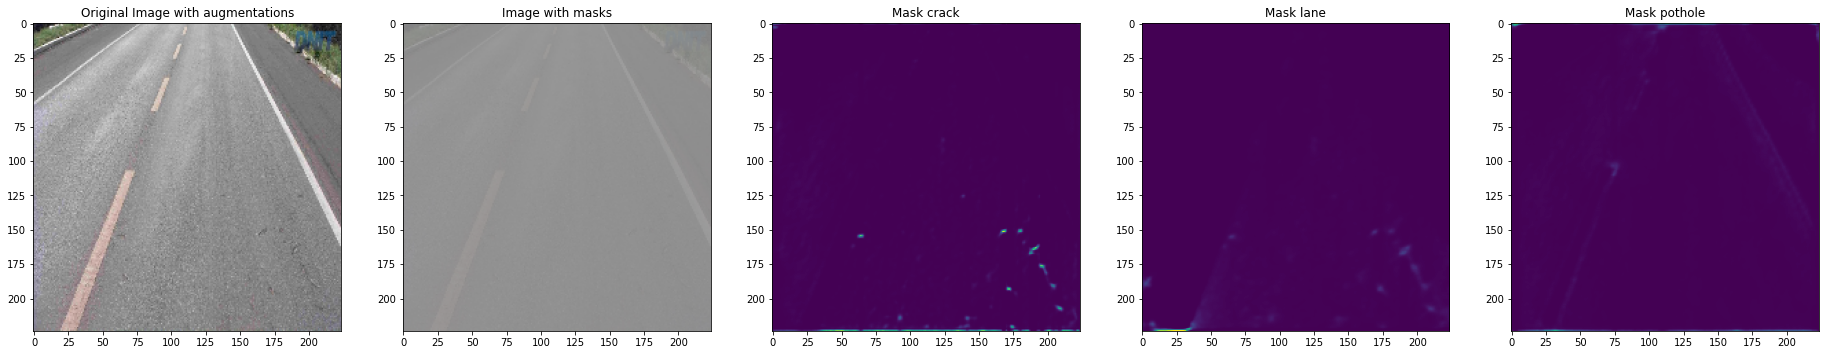

In [100]:
image = read_rgb(img_path)
image = cv2.resize(image, (224, 224))
print("Inference")
visualize(
    image=image,
    masks=_preds,
    classes=classes,
    colors=colors
)

Ground Truth


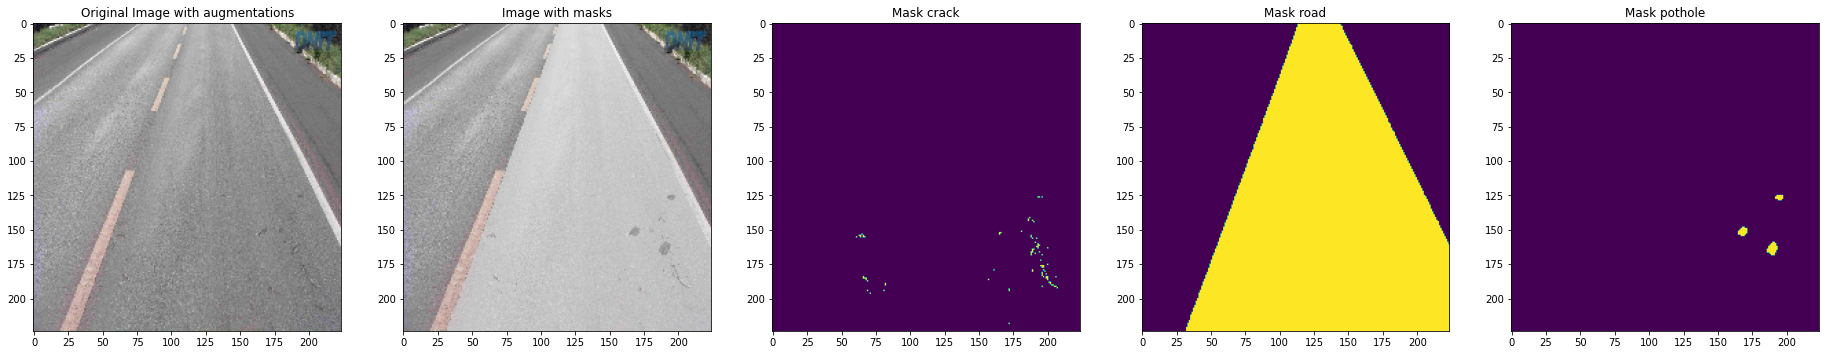

In [95]:
image = read_rgb(img_path)
image = cv2.resize(image, (224, 224))
print("Ground Truth")
visualize(
    image=image,
    masks=mask.detach().numpy().transpose(1, 2, 0),
    classes=["crack", "road", "pothole"],
    colors=colors
)